## 이용량 결측치 처리

#### 노선 이용량을 활용성 지수로 변환
* 이용량 결측치 처리 과정에서 더 정확하게 분석하고 시각화한 후 예측
* 예측 성능 검증 진행

In [247]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [248]:
meta_data = pd.read_csv("../data/total_data.csv")
data = pd.read_csv("../data/여진_total_busdata.csv")

In [249]:
data["총인구수"] = meta_data["총인구수"]
data["노인(수)"] = meta_data["노인(수)"]
data["총인구수"] = data["총인구수"].apply(lambda x: int(x.replace(",", "")))
data["노인(수)"] = data["노인(수)"].apply(lambda x: int(x.replace(",", "")))

In [250]:
data = data[data['city_name'] != '산청군']

In [251]:
data.columns

Index(['city_name', 'routeno', 'routetp', 'startnodenm', 'endnodenm',
       'startvehicletime', 'endvehicletime', 'intervaltime', 'intervalsattime',
       'intervalsuntime', 'usage', '노선정류장수', '노선거리(km)', '굴곡도', 'start', 'end',
       'total_operating_time', 'interval_avg', 'num_bus', '총인구수', '노인(수)'],
      dtype='object')

In [252]:
use_col = [ 
    'city_name',
    'routetp',
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)', 
    'usage'
    ]

In [253]:
data = data[use_col]
data.head()

,city_name,routetp,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage
0,창원시,마을버스,105,55.9,2.0,990.0,40.000000,24,1003731,276574,33931.0
1,창원시,마을버스,83,53.5,1.7,865.0,170.000000,5,1003731,276574,2558.0
2,창원시,마을버스,74,43.8,2.6,545.0,220.000000,2,1003731,276574,299.0
3,창원시,마을버스,35,21.1,1.0,1010.0,12.142857,83,1003731,276574,63612.0
4,창원시,마을버스,39,8.8,1.8,1000.0,17.000000,58,1003731,276574,68306.0


In [254]:
data['routetp'].value_counts()

routetp
농어촌(일반)버스    1053
일반버스          988
지선버스          209
간선버스           88
좌석버스           58
마을버스           48
심야버스            2
급행버스            1
Name: count, dtype: int64

### split to train/valid/test set

In [255]:
from sklearn.model_selection import train_test_split
data_train = data[~data['usage'].isna()]
data_test = data[data['usage'].isna()]

import numpy as np
data_train['usage'] = np.log1p(data_train['usage'])

### 범주형 변수 전처리 (One-hot Encoding)

#### routetp 

In [256]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

t_routetp = data_train['routetp']
v_routetp = data_test['routetp']

# 전체 데이터에서 고유한 범주를 추출
all_routetp = np.unique(data['routetp'])

ohe = OneHotEncoder(
    categories=[all_routetp],
    sparse_output=False
    )
ohe.fit(t_routetp.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_routetp.values.reshape(-1,1)) #data_train
dense_matrix_val = ohe.transform(v_routetp.values.reshape(-1,1)) #data_test

In [257]:
# tdata_train, dense_matrix_tr 데이터 합치기

data_train = pd.concat([data_train.reset_index(drop=True),
pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
axis=1)

In [258]:
# data_test, dense_matrix_val 데이터 합치기

data_test = pd.concat([data_test.reset_index(drop=True), 
pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], axis=1)

#### city_name

In [259]:
t_city = data_train['city_name']
v_city = data_test['city_name']

# 전체 데이터에서 고유한 범주를 추출
all_city = np.unique(data['city_name'])

ohe = OneHotEncoder(
    categories=[all_city],
    sparse_output=False
    )
ohe.fit(t_city.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_city.values.reshape(-1,1)) #data_train
dense_matrix_val = ohe.transform(v_city.values.reshape(-1,1)) #data_test

In [260]:
# data_train, dense_matrix_tr 데이터 합치기

data_train = pd.concat([data_train.reset_index(drop=True),
pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
axis=1)

In [261]:
# data_test, dense_matrix_val 데이터 합치기

data_test = pd.concat([data_test.reset_index(drop=True), 
pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], axis=1)

In [262]:
data_train = data_train.drop(columns=['routetp','city_name'])
data_test = data_test.drop(columns=['routetp','city_name'])

In [263]:
data_train

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,105,55.9,2.0,990.000000,40.000000,24,1003731,276574,10.432114,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,83,53.5,1.7,865.000000,170.000000,5,1003731,276574,7.847372,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,74,43.8,2.6,545.000000,220.000000,2,1003731,276574,5.703782,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,35,21.1,1.0,1010.000000,12.142857,83,1003731,276574,11.060573,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,39,8.8,1.8,1000.000000,17.000000,58,1003731,276574,11.131768,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,54,52.7,1.4,405.855659,124.728571,3,40756,23160,4.454347,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1172,16,14.0,1.1,405.855659,124.728571,3,40756,23160,3.135494,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1173,20,16.3,2.3,405.855659,124.728571,3,40756,23160,2.995732,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1174,21,25.5,1.6,405.855659,124.728571,3,40756,23160,3.135494,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 연속형 변수 전처리

In [264]:
col = [ 
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)'
    ]

In [265]:
# Standartscaler 사용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train[col])

data_train[col] = scaler.transform(data_train[col])
data_test[col] = scaler.transform(data_test[col])

In [246]:
# MinMaxxscaler 사용
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data_train[col])

data_train[col] = scaler.transform(data_train[col])
data_test[col] = scaler.transform(data_test[col])

In [266]:
total = pd.concat([data_train, data_test],axis=0)
total

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
0,0.866813,0.947937,0.023726,1.431283,-1.195293,2.545143,2.269349,2.345416,10.432114,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.313408,0.824101,-0.399022,1.041704,0.512932,-0.003764,2.269349,2.345416,7.847372,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.087015,0.323596,0.869220,0.044382,1.169942,-0.406224,2.269349,2.345416,5.703782,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.894021,-0.847689,-1.385432,1.493616,-1.561342,10.460174,2.269349,2.345416,11.060573,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.793402,-1.482350,-0.258106,1.462450,-1.497518,7.106347,2.269349,2.345416,11.131768,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,-1.095259,-0.395486,0.023726,-0.389280,-0.081943,-0.272071,-0.851338,-0.811294,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1267,-1.095259,-0.395486,0.023726,-0.389280,-0.081943,-0.272071,-0.851338,-0.811294,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1268,-1.095259,-0.395486,0.023726,-0.389280,-0.081943,-0.272071,-0.851338,-0.811294,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1269,-1.095259,-0.395486,0.023726,-0.389280,-0.081943,-0.272071,-0.851338,-0.811294,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [267]:
#from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 정량적 (통계적 수치)

In [268]:
# usage 결측치 처리
impute_total_data = pd.DataFrame(IterativeImputer(random_state=0).fit_transform(total))
impute_total_data.columns = total.columns
impute_total_data["usage"] = impute_total_data["usage"].round(0)

In [269]:
# 로그변환 원래대로
impute_total_data["usage"] = np.expm1(impute_total_data["usage"])

In [196]:
#impute_total_data[1357,:]

,거제시,거창군,고성군,김해시,남해군,밀양시,사천시,산청군,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
1357,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
impute_total_data[impute_total_data['usage'] < 0]

,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage,간선버스,...,양산시,의령군,진주시,창녕군,창원시,통영시,하동군,함안군,함양군,합천군
1351,-1.422271,-1.054083,64.98591,-0.38928,-0.081943,-0.272071,-0.655287,-0.529785,-0.864665,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


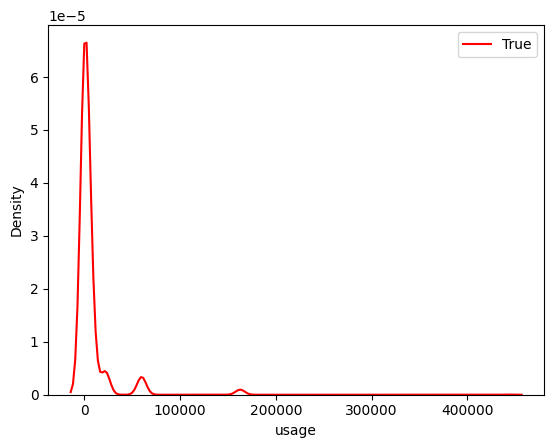

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(impute_total_data["usage"], color="r", label="True")
plt.legend()